<title> project </title>

In [1]:
## Load libraries
library(tidyverse)
library(tidymodels)
#library(tidyclust)
#library(GGally)

#library(lubridate)
library(RColorBrewer)
library(repr)
options(repr.matrix.max.rows = 6)



── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# Introduction


First, let us inspect the data and play a bit with it

Research question: can age, gender, experience, and played hours predict whether a user will subscribe to a gaming newsletter?


In [2]:
players <- read_csv("https://raw.githubusercontent.com/Mateo-dmngz-D/dsci-100-project/refs/heads/main/players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


### What missing data do we have?

In [3]:
sessions <- read_csv("https://raw.githubusercontent.com/Mateo-dmngz-D/dsci-100-project/refs/heads/main/sessions.csv")
sessions

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


In [4]:
## sessions
missing_s <- colSums(is.na(sessions))
missing_s

missing_s_rows <- sessions |>
    filter(is.na(end_time))
missing_s_rows

hashedEmail          start_time            end_time original_start_time 
                  0                   0                   2                   0 
  original_end_time 
                  2

hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
55d24216db39c27e1f17cc43d3127cbf8ed76ada6d098202b53ded319855e2c1,27/08/2024 17:06,NA,1.72478e+12,NA
b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319,15/09/2024 04:21,NA,1.72637e+12,NA


In [5]:
## players
missing_p <- colSums(is.na(players))
missing_p

missing_p_rows <- players |>
    filter(is.na(Age))
missing_p_rows

experience    subscribe  hashedEmail played_hours         name       gender 
           0            0            0            0            0            0 
         Age 
           2

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Regular,TRUE,7d71c49cbbce8dcf0276b2bfecfa2d16f22cb31a4024556d6085884298f2ee8d,0.1,Devin,Two-Spirited,NA
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


### g

# Methods

In [6]:
## Read data
players_raw <- read_csv("https://raw.githubusercontent.com/Mateo-dmngz-D/dsci-100-project/refs/heads/main/players.csv")
players_raw

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [7]:
## Clean
players_clean <- players_raw |>
    select(-hashedEmail, -name) |>
    mutate(experience = as_factor(experience),
           subscribe = as_factor(subscribe),
           gender = as_factor(gender)) |>
    filter(!is.na(Age))

players_clean



experience,subscribe,played_hours,gender,Age
<fct>,<fct>,<dbl>,<fct>,<dbl>
Pro,TRUE,30.3,Male,9
Veteran,TRUE,3.8,Male,17
Veteran,FALSE,0.0,Male,17
⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,0.3,Male,22
Amateur,FALSE,0.0,Prefer not to say,17
Amateur,FALSE,2.3,Male,17


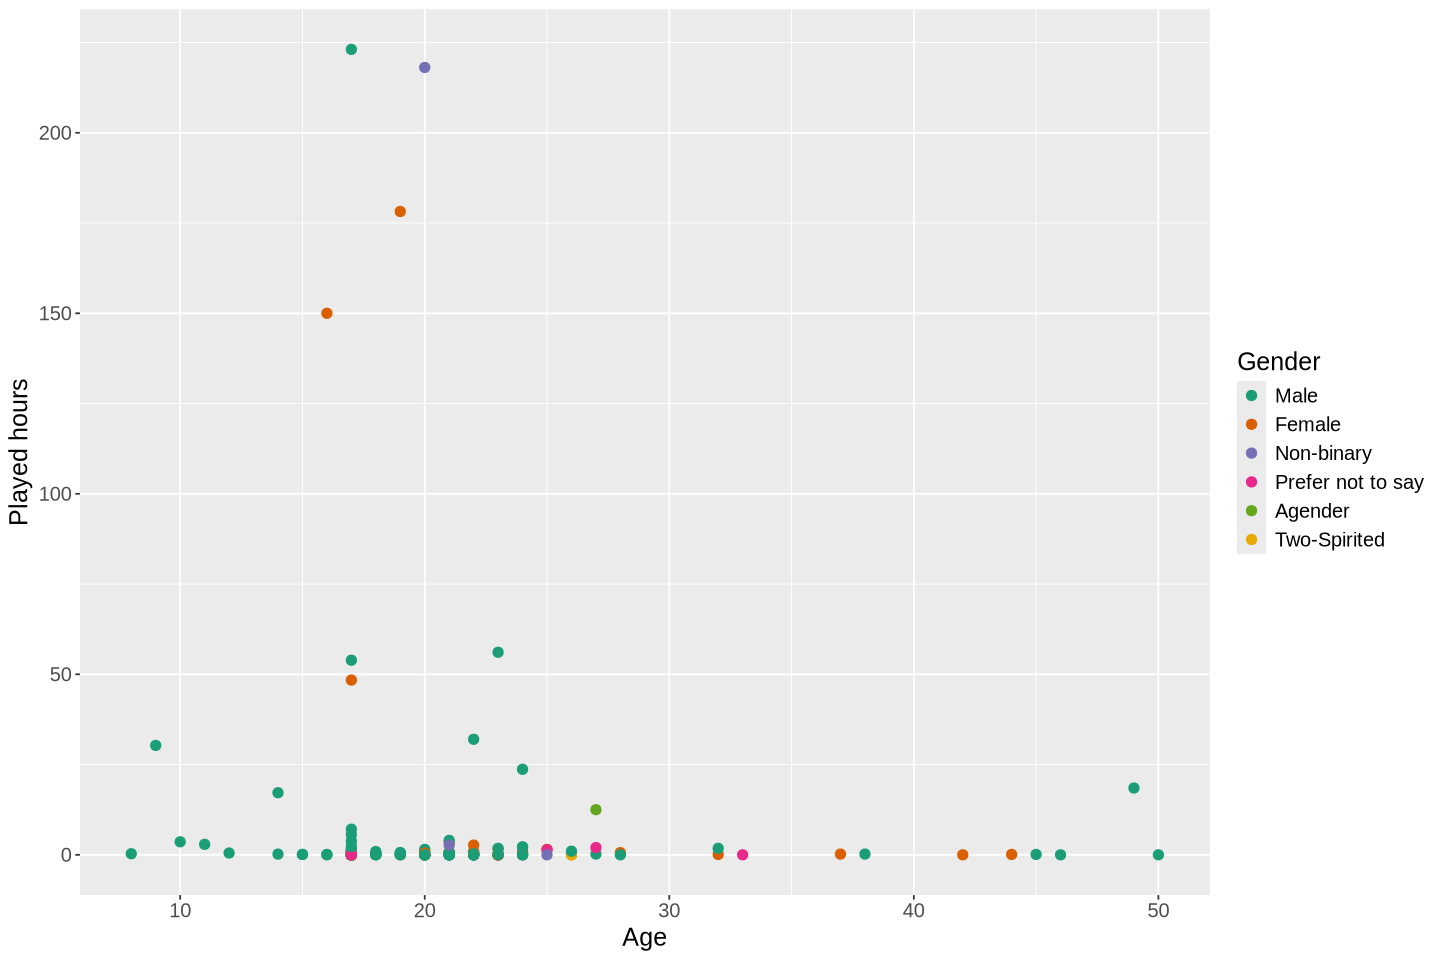

In [8]:
## Inspect data
options(repr.plot.width = 12, repr.plot.height = 8)


age_played_plot <- players_clean |>
    select(played_hours, Age, gender) |>
    ggplot(aes(x = Age, y = played_hours, color = gender)) + #, shape = gender
    geom_point(alpha = 1, size = 2.5) +
    labs(y = "Played hours", color = "Gender") + #, shape = "Gender"
    #scale_y_log10() +
    scale_color_brewer(palette = "Dark2") +
    theme(text = element_text(size = 15))

age_played_plot

In [9]:
### Since doing prediction, must split data into training and testing sets

set.seed(3421)

players <- initial_split(players_clean, prop = 0.75, strata = subscribe)
players_training <- training(players)
players_testing <- testing(players)

### Start usual modelling & coding stuff



In [10]:
## Recipe

p1_recipe <- recipe(subscribe ~ ., data = players_training) |>
    step_scale(Age, played_hours) |>
    step_center(Age, played_hours)

### Tuning

In [11]:
## Model
p1_tuning_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

## Folds
p1_vfold <- vfold_cv(players_training, v = 5, strata = subscribe)

## Workflow
p1_workflow <- workflow() |>
    add_recipe(p1_recipe) |>
    add_model(p1_tuning_spec)

p1_workflow


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [12]:
## Cross-validation
gridvals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

## Choosing K
p1_results <- p1_workflow |>
    tune_grid(resamples = p1_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    as.data.frame() |>
    arrange(desc(mean))
p1_results


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
6,accuracy,binary,0.7166502,5,0.03053806,Preprocessor1_Model06
5,accuracy,binary,0.7099836,5,0.02644210,Preprocessor1_Model05
7,accuracy,binary,0.7023645,5,0.02822811,Preprocessor1_Model07
⋮,⋮,⋮,⋮,⋮,⋮,⋮
3,accuracy,binary,0.6683251,5,0.01707264,Preprocessor1_Model03
2,accuracy,binary,0.5926601,5,0.02685344,Preprocessor1_Model02
1,accuracy,binary,0.5719540,5,0.03152570,Preprocessor1_Model01


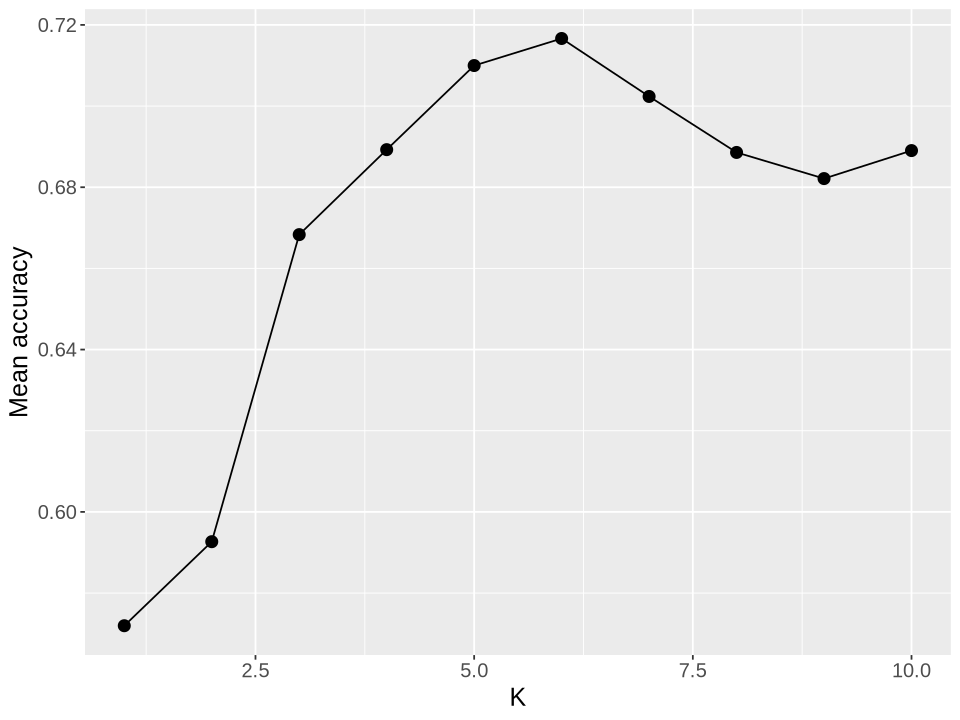

In [13]:
## Choosing k
options(repr.plot.width = 8, repr.plot.height = 6)

p1_k_plot <- p1_results |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point(size = 3) +
    geom_line() +
    labs(x = "K", y = "Mean accuracy") +
    theme(text = element_text(size = 15))
p1_k_plot

We choose $k = 6$ because it largest estimate, 71.6%. Note that both $k = 5$ and $k = 7$ have close estimates at 71% and 70.2%, respectively. This gives reliability to our choice of $k$ given the uncertainty of the estimates.

In [14]:
p1_best_k <- 6

### Model with best K

In [15]:
## Create model with best K
p1_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = p1_best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

## Workflow
p1_fit <- workflow() |>
    add_recipe(p1_recipe) |>
    add_model(p1_best_spec) |>
    fit(players_training)

## Predict + metrics
p1_accuracy <- p1_fit |>
    predict(players_training) |>
    bind_cols(players_training) |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate) |>
    pull()

p1_accuracy

[1] 0.8068966

# Results

# Discussion

# Conclusion

# References

Spinu, Vitalie, Garrett Grolemund, and Hadley Wickham. 2021. lubridate R package. https://lubridate.tidyverse.org/.

In [16]:
# set.seed(2000) # DO NOT REMOVE

# ## Recipe
# credit_knn_recipe <- recipe(Balance ~ ., data = credit_training) |>
#     step_scale(all_predictors()) |>
#     step_center(all_predictors())

# ## Model
# credit_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
#     set_engine("kknn") |>
#     set_mode("regression")

# ## Folds
# credit_vfold <- vfold_cv(credit_training, v = 5, strata = Balance)

# ## Workflow
# credit_knn_workflow <- workflow() |>
#     add_recipe(credit_knn_recipe) |>
#     add_model(credit_knn_spec)

# #credit_knn_workflow


# ## <<<<<<<<<<«««««|||||»»»»»>>>>>>>>>>
# ## <<<<<<<<<<«««««|||||»»»»»>>>>>>>>>>


# ## Cross-validation
# gridvals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

# ## Choosing K
# credit_knn_results <- credit_knn_workflow |>
#     tune_grid(resamples = credit_vfold, grid = gridvals) |>
#     collect_metrics() |>
#     filter(.metric == "rmse")

# best_k <- credit_knn_results |>
#     slice_min(mean, n = 1) |>
#     pull(neighbors)


# ## <<<<<<<<<<«««««|||||»»»»»>>>>>>>>>>
# ## <<<<<<<<<<«««««|||||»»»»»>>>>>>>>>>


# ## Create model with best K
# credit_knn_best <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
#     set_engine("kknn") |>
#     set_mode("regression")

# ## Workflow
# credit_knn_fit <- workflow() |>
#     add_recipe(credit_knn_recipe) |>
#     add_model(credit_knn_best) |>
#     fit(credit_training)

# ## Predict + metrics
# knn_rmspe <- credit_knn_fit |>
#     predict(credit_training) |>
#     bind_cols(credit_training) |>
#     metrics(truth = Balance, estimate = .pred) |>
#     filter(.metric == "rmse") |>
#     select(.estimate) |>
#     pull()

# knn_rmspe

# diff = (knn_rmspe - lm_rmspe)/lm_rmspe
# diff